In [1]:
from experiment_utils import *
from model import ViT
from configs import b16_config
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
config = b16_config()
config.update({'num_classes':10})
model = load_model(ViT, 'pretrained/cifar10_224.pth', config)

In [3]:
import torch
from thop import profile

macs, params = profile(model, inputs=(torch.randn(1, 3, 224, 224),))
print('MACs:', f'{macs/1e9:.2f} G')
print('Params', f'{params/1e6:.2f} M')

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
MACs: 16.86 G
Params 85.65 M


In [4]:
dataset = CIFAR10(root='../datasets', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

data = dataset.data
label = dataset.targets

Files already downloaded and verified


In [5]:
model_summary(model, 3, 224, 'cpu')

                                                   Kernel Shape  \
Layer                                                             
0_to_patch                                                    -   
1_linear_projection                                  [768, 768]   
2_transformer_encoder.blocks.0.LayerNorm_layer_...        [768]   
3_transformer_encoder.blocks.0.msa.Linear_fc_q       [768, 768]   
4_transformer_encoder.blocks.0.msa.Linear_fc_k       [768, 768]   
5_transformer_encoder.blocks.0.msa.Linear_fc_v       [768, 768]   
6_transformer_encoder.blocks.0.msa.Dropout_dropout            -   
7_transformer_encoder.blocks.0.msa.Linear_fc_o       [768, 768]   
8_transformer_encoder.blocks.0.Dropout_dropout                -   
9_transformer_encoder.blocks.0.LayerNorm_layer_...        [768]   
10_transformer_encoder.blocks.0.mlp.Linear_fc1      [768, 3072]   
11_transformer_encoder.blocks.0.mlp.GELU_activa...            -   
12_transformer_encoder.blocks.0.mlp.Dropout_dro...            

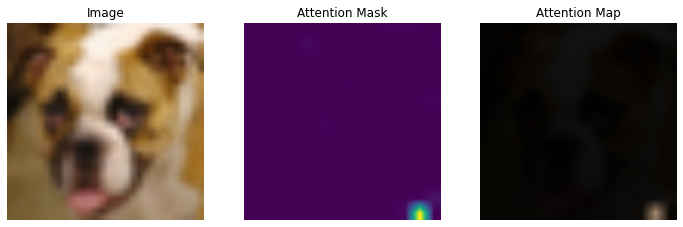

In [6]:
import random

plot_attention_map(data[random.randint(0, 10000)], model, 224, 'cpu')

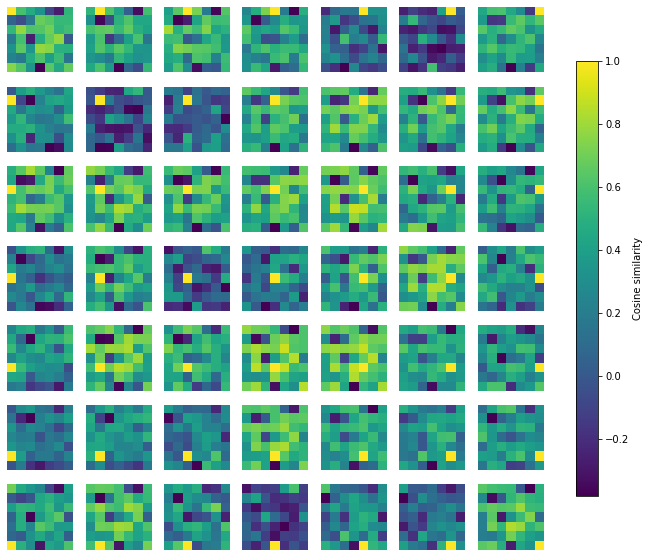

In [7]:
pos_embeddings = model.pos_embedding.squeeze()[1:, :]
plot_pos_emb_similarity(pos_embeddings, 7, 7)

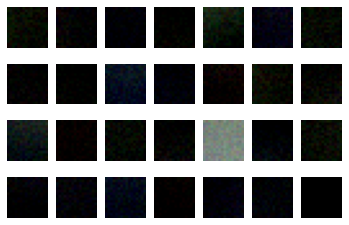

In [8]:
import logging
logger = logging.getLogger()
logger.setLevel(100)

embed_filters = model.linear_projection.weight
plot_rgb_filters(embed_filters, 3, 16)

In [15]:
from modules import TransformerEncoder

all_block = []
for model_child in list(model.children()):
    if type(model_child) != torch.nn.modules.container.ModuleList:
        if isinstance(model_child, TransformerEncoder):
            for i in range(12):
                all_block.append(model_child.blocks[i])
        else:
            all_block.append(model_child)

In [20]:
all_block[2]

TransformerEncoderBlock(
  (msa): MSA(
    (fc_q): Linear(in_features=768, out_features=768, bias=True)
    (fc_k): Linear(in_features=768, out_features=768, bias=True)
    (fc_v): Linear(in_features=768, out_features=768, bias=True)
    (fc_o): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (mlp): MLP(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)